In [2]:
import datasets
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import openai
from sklearn.model_selection import train_test_split
import json
import time 

In [3]:
openai.api_key = ""

In [4]:
df, test_df = pd.read_csv('Amazon_Reviews_Train.csv'), pd.read_csv('Amazon_Reviews_Test.csv')

In [5]:
num_labels = 5
id_to_label = {
    0: "Bad",
    1: "Good",
    2: "Neutral",
    3: "Very Good",
    4: "Excellent"
}

label_to_id = {value : key for key , value in  id_to_label.items()}


In [6]:
df['reviews.rating'] = df['reviews.rating'].map(id_to_label)
test_df['reviews.rating'] = test_df['reviews.rating'].map(id_to_label)

In [7]:
df

,brand,primaryCategories,reviews.numHelpful,reviews.rating,reviews.text
0,2,Health & Beauty,NaN,Excellent,Amazon's batteries are great. I've had no prob...
1,2,Health & Beauty,NaN,Excellent,always need batteries
2,0,Electronics,0.0,Very Good,It's pretty good for what it is designed to do...
3,0,Electronics,0.0,Very Good,I love it it comes with a 12 month kids subscr...
4,0,Electronics,0.0,Very Good,"For the price, it is quite a nice tablet. I mu..."
...,...,...,...,...,...
5995,0,Electronics,0.0,Very Good,Bought for wife who is not into the techie wor...
5996,0,Electronics,0.0,Very Good,I thought it would be good for my 2year old he...
5997,2,Health & Beauty,NaN,Bad,Wrong Item
5998,0,"Electronics,Media",16.0,Very Good,"I got oasis yesterday, very lighweight compare..."


In [8]:
categories = df['reviews.rating'].unique()

In [9]:
categories

array(['Excellent', 'Very Good', 'Neutral', 'Good', 'Bad'], dtype=object)

In [10]:
def text_to_openai_json(data,filename):
    """
    Converts a given dataset into a JSON Lines (JSONL) file suitable for OpenAI's GPT-3.5 turbo model.
    
    Args:
        data (DataFrame or similar data structure): Input data containing text and labels.

    The function processes the input data row by row, constructing conversations for each row with a system message, user message, and an assistant message. It then writes the generated conversation data to a JSONL file.
 
    """
    # Initialize an empty list to store conversation data
    message_list = []

    # Iterate through the rows in the input data
    for _, row in data.iterrows():
        # Create a system message as an initial instruction
        system_message = {
            "role": "system",
            "content": f"given the following text: find the category in: {categories} that is most closely associated with it. Return only the category name"
        }

        # Append the system message to the conversation
        message_list.append({"messages": [system_message]})

        # Create a user message based on the 'text' column from the data
        user_message = {
            "role": "user",
            "content": row['reviews.text']
        }

        # Append the user message to the conversation
        message_list[-1]["messages"].append(user_message)

        # Create an assistant message based on the 'coarse_label' column from the data
        assistant_message = {
            "role": 'assistant',
            "content": row['reviews.rating']
        }

        # Append the assistant message to the conversation
        message_list[-1]["messages"].append(assistant_message)

    # Write the conversation data to a JSON Lines (JSONL) file
    with open(filename, "w") as json_file:
        for message in message_list:
            # Serialize the conversation data to JSON and write it to the file
            json.dump(message, json_file)
            json_file.write("\n")

In [11]:
system_content =  f"given the following text: find the category in: {categories} that is most closely associated with it. Return only the category name only in following format"

In [12]:
system_content

"given the following text: find the category in: ['Excellent' 'Very Good' 'Neutral' 'Good' 'Bad'] that is most closely associated with it. Return only the category name only in following format"

In [13]:
from sklearn.metrics import precision_recall_fscore_support

In [14]:
def zero_shot_model(data,model_id):
    pred = []
    for row in data["reviews.text"]:
        completion = openai.ChatCompletion.create(
            model= model_id ,
            messages=[
                {"role": "system", "content": system_content },
                {"role": "user", "content": row }
            ])
        
        print(f'text: {row}')
        print(completion.choices[0].message.content)
        pred.append(completion.choices[0].message.content)
    pred_df = pd.DataFrame({'reviews.text': data["reviews.text"], 'reviews.rating' : data['reviews.rating'], 'few-shot predictions' : pred })
    
    return pred_df

In [15]:
cumulative_increment = 0
model_id = 'gpt-3.5-turbo-0301'
all_model_id = []

In [16]:
def fine_tune_model(model_id,num_label,pred_df):
    incorrection_pred_df = pred_df[pred_df['reviews.rating'] != pred_df['few-shot predictions']][:num_label]
    filename = f'ft_increment_{num_label}.jsonl'
    text_to_openai_json(incorrection_pred_df, filename)
    loader = openai.File.create(file=open(filename, "rb"), purpose='fine-tune')
    fine_tuning_job = openai.FineTuningJob.create(training_file=loader.id, model="gpt-3.5-turbo")
    return fine_tuning_job.id

In [22]:
def ft_accuracy(data,model_id):
    pred = []
    for row in data["reviews.text"]:
        completion = openai.ChatCompletion.create(
            model= model_id ,
            messages=[
                {"role": "system", "content": system_content },
                {"role": "user", "content": row }
            ])
        
        print(f'text: {row}')
        print(completion.choices[0].message.content)
        pred.append(completion.choices[0].message.content)
        
    accuracy = accuracy_score(data['reviews.rating'], pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    precision, recall, f1, _ = precision_recall_fscore_support(data['reviews.rating'], pred, average='macro',zero_division=1)
    
    return accuracy, precision, recall, f1, pred

In [18]:
test_df.head()

,brand,primaryCategories,reviews.numHelpful,reviews.rating,reviews.text
0,2,Health & Beauty,NaN,Very Good,A lot of battery for the buck.
1,0,Electronics,0.0,Very Good,Great tablet for toddlers. Easy yet fun. I pur...
2,2,Health & Beauty,NaN,Bad,I love Amazon and Amazon products but....MAJOR...
3,2,Health & Beauty,NaN,Excellent,Fast delivery of product as advertised.
4,2,Health & Beauty,NaN,Very Good,"Battery life is equivalent to name-brand, mid-..."


In [20]:
pred_df = zero_shot_model(model_id='gpt-3.5-turbo-0301', data = test_df[:400])

text: A lot of battery for the buck.
Good
text: Great tablet for toddlers. Easy yet fun. I purchased two tablets for my grandkids, ages 2 and 4. They both love it and enjoy playing with it.
Excellent
text: I love Amazon and Amazon products but....MAJOR disappointment. While not much less cost that Duracell or Energizer the Amazon brand batteries were a ripoff! Only lasted a third of the time in the devices I have used the competitor's batteries in before.....bummer :(
Bad
text: Fast delivery of product as advertised.
Excellent
text: Battery life is equivalent to name-brand, mid-range batteries, which makes it quite a bargain. I am often surprised when I change batteries in a high-use device and realize how long these batteries last. They also have a nice look and when you buy a brick of them they are conveniently wrapped in bundles of 4, which makes for easy storage. They wont replace Duracell's in my high-power-drain equipment, but for everything else these are great.
Good
text: My so

In [21]:
def wait_for_fine_tuning(job_id):
    while True:
        response = openai.FineTuningJob.retrieve(job_id)
        print(response["fine_tuned_model"])
        if response["fine_tuned_model"]:
            print(response["fine_tuned_model"])
            return response["fine_tuned_model"]
        time.sleep(60)  # Check every 60 seconds

In [23]:
model_ids = []
accs = [] 
precisions = [] 
recalls = [] 
f1s = []
labels = []
label_count = []
count = 0
for i in range(15):
    count += 10
    label_count.append(count)
    ft_id = fine_tune_model(model_id = 'gpt-3.5-turbo-0301', num_label=label_count, pred_df=pred_df)
    if wait_for_fine_tuning(ft_id) is not None:
        model_ids.append(wait_for_fine_tuning(ft_id))
        accuracy, precision, recall, f1, pred = ft_accuracy(data=test_df[:400],model_id=(wait_for_fine_tuning(ft_id)))
        labels.append(label_count)
        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

None
None
None
None
None
None
None
ft:gpt-3.5-turbo-0613:personal::8UcvQ0zd
ft:gpt-3.5-turbo-0613:personal::8UcvQ0zd
ft:gpt-3.5-turbo-0613:personal::8UcvQ0zd
ft:gpt-3.5-turbo-0613:personal::8UcvQ0zd
ft:gpt-3.5-turbo-0613:personal::8UcvQ0zd
ft:gpt-3.5-turbo-0613:personal::8UcvQ0zd
text: A lot of battery for the buck.
Very Good
text: Great tablet for toddlers. Easy yet fun. I purchased two tablets for my grandkids, ages 2 and 4. They both love it and enjoy playing with it.
Very Good
text: I love Amazon and Amazon products but....MAJOR disappointment. While not much less cost that Duracell or Energizer the Amazon brand batteries were a ripoff! Only lasted a third of the time in the devices I have used the competitor's batteries in before.....bummer :(
Very Good
text: Fast delivery of product as advertised.
Very Good
text: Battery life is equivalent to name-brand, mid-range batteries, which makes it quite a bargain. I am often surprised when I change batteries in a high-use device and real

In [25]:
accs

[0.5375,
 0.49,
 0.5275,
 0.5575,
 0.65,
 0.61,
 0.6125,
 0.575,
 0.6475,
 0.71,
 0.6625,
 0.645,
 0.57,
 0.585,
 0.6375]

# Confusion Matrix


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt

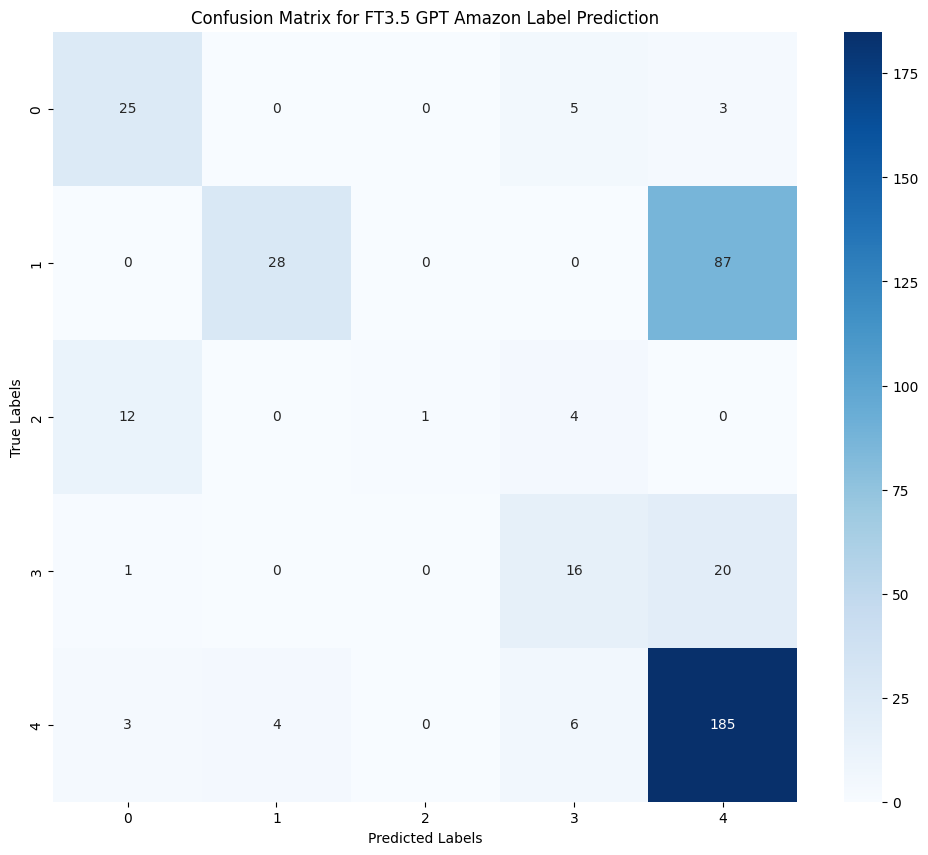

In [28]:
cm = confusion_matrix( test_df['reviews.rating'][:400],pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for FT3.5 GPT Amazon Label Prediction')
plt.show()

In [43]:
data = ({ 'Pred':  pred,'Actual':  test_df['reviews.rating'][:400]})

In [44]:
pd.DataFrame(data).to_csv('FT-GPT3.5_turbo_amazon_pred.csv',index=False)